## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
import sklearn
import pandas as pd 
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage import io
from random import sample 

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
import sklearn.model_selection as skl
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
87480,00021610_027.png,No Finding,27,21610,45,M,PA,2992,2769,0.143,0.143,NaN,/data/images_010/images/00021610_027.png
86479,00021321_006.png,Effusion|Infiltration,6,21321,49,F,PA,2992,2991,0.143,0.143,NaN,/data/images_010/images/00021321_006.png
4061,00001101_021.png,Infiltration,21,1101,45,F,PA,2544,3056,0.139,0.139,NaN,/data/images_001/images/00001101_021.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
print(type(all_labels))
all_labels = [x for x in all_labels if len(x)>0]
print(type(all_labels))
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label) > 1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

all_xray_df.sample(3)
# Todo

<class 'numpy.ndarray'>
<class 'list'>
All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
6794,00001831_000.png,Cardiomegaly,0,1831,43,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
111552,00030536_002.png,No Finding,2,30536,56,F,PA,2021,2021,0.194308,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
40448,00010531_009.png,No Finding,9,10531,28,F,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda x: 1 if x==1.0 else 0)
all_xray_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0


## Create your training and testing data:

In [5]:
def create_splits(dataframe):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia

    train_df, valid_df = skl.train_test_split(all_xray_df, 
                                   test_size = 0.2, 
                                   stratify = all_xray_df['pneumonia_class'])
    return train_df, valid_df

train_df, valid_df = create_splits(all_xray_df)

print("Number of images in training data: {}".format(len(train_df)))
print("Number of images in testing data: {}".format(len(valid_df)))
print(train_df['pneumonia_class'].sum()/len(train_df))
print(valid_df['pneumonia_class'].sum()/len(valid_df))

Number of images in training data: 89696
Number of images in testing data: 22424
0.012765340706386016
0.012754191937210132


In [6]:
p_inds = train_df[train_df.pneumonia_class==1].index.tolist()
np_inds = train_df[train_df.pneumonia_class==0].index.tolist()

np_sample = sample(np_inds,len(p_inds))
train_df = train_df.loc[p_inds + np_sample]

train_df['pneumonia_class'].sum()/len(train_df)

0.5

In [8]:
p_inds = valid_df[valid_df.pneumonia_class==1].index.tolist()
np_inds = valid_df[valid_df.pneumonia_class==0].index.tolist()

np_sample = sample(np_inds, 4 * len(p_inds))
valid_df = valid_df.loc[p_inds + np_sample]

In [9]:
train_df['pneumonia_class'] = train_df['Pneumonia'].map(lambda x: '1' if x==1.0 else '0')
valid_df['pneumonia_class'] = valid_df['Pneumonia'].map(lambda x: '1' if x==1.0 else '0')
valid_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
19383,00005138_009.png,Pneumonia,9,5138,54,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
89780,00022290_017.png,Effusion|Pneumonia,17,22290,58,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
67949,00016786_001.png,Infiltration|Pneumonia,1,16786,23,F,AP,3056,2544,0.139,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
82641,00020322_008.png,Infiltration|Pneumonia,8,20322,44,M,AP,3056,2544,0.139,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
56146,00014004_027.png,Edema|Pneumonia,27,14004,58,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [10]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    my_idg = ImageDataGenerator(rescale=1./ 255.0,
                                  horizontal_flip = True, 
                                  vertical_flip = False, 
                                  height_shift_range= 0.1, 
                                  width_shift_range=0.1, 
                                  rotation_range=15, 
                                  shear_range = 0.1,
                                  zoom_range=0.1)
    
    
    return my_idg

my_idg = my_image_augmentation()

def make_train_gen(my_idg, train_data):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
     # Todo
    train_gen = my_idg.flow_from_dataframe(dataframe=train_data, 
                                                 directory=None, 
                                                 x_col = 'path',
                                                 y_col = 'pneumonia_class',
                                                 class_mode = 'binary',
                                                 target_size = (224, 224), 
                                                 batch_size = 100
                                                 )

    return train_gen

train_gen = make_train_gen(my_idg, train_df)

def make_val_gen(valid_df):
    
    val_idg = ImageDataGenerator(rescale=1. / 255.0)

    val_gen = val_idg.flow_from_dataframe(dataframe=valid_df, 
                                                 directory=None, 
                                                 x_col = 'path',
                                                 y_col = 'pneumonia_class',
                                                 class_mode = 'binary',
                                                 target_size = (224, 224), 
                                                 batch_size = 100)
    return val_gen

val_gen = make_val_gen(valid_df)



Found 2290 validated image filenames belonging to 2 classes.
Found 1430 validated image filenames belonging to 2 classes.


In [11]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

0.0
1.0
1.0
0.0
1.0
1.0
1.0
0.0
1.0
1.0
0.0
0.0
0.0
0.0
1.0
0.0


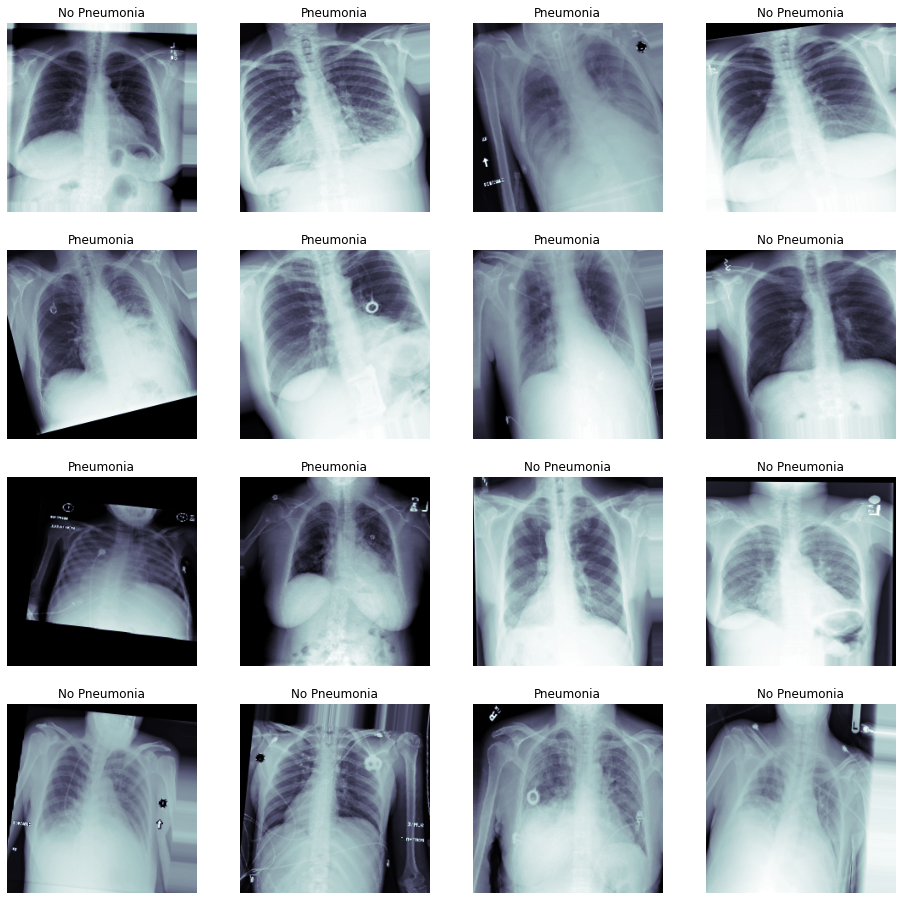

In [12]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    print(c_y)
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [13]:
def load_pretrained_model():
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    return vgg_model

pretrained_model = load_pretrained_model()
pretrained_model.summary()

553467904/553467096 [==============================] - 12s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________

In [14]:
def build_my_model(pretrained_model):

    new_model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    new_model.add(pretrained_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    new_model.add(Flatten())
    
    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    new_model.add(Dense(512, activation='relu'))
    
    # Add a dropout-layer which may prevent overfitting and
    # improve generalization ability to unseen data e.g. the test-set.
    new_model.add(Dropout(0.2))

    new_model.add(Dense(256, activation='relu'))

    new_model.add(Dropout(0.2))

    new_model.add(Dense(256, activation='relu'))
    
    new_model.add(Dropout(0.2))

    new_model.add(Dense(128, activation='relu'))
    
    new_model.add(Dropout(0.2))

    new_model.add(Dense(64, activation='relu'))

    # Add a dense (aka. fully-connected) layer.
    # Change the activation function to sigmoid 
    # so output of the last layer is in the range of [0,1] 
    new_model.add(Dense(1, activation='sigmoid'))

    return new_model

model = build_my_model(pretrained_model)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               12845568  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)              

In [15]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting
from keras.optimizers import Adam
# Todo
optimizer = Adam(learning_rate=0.0001)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

weight_path="{}_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'binary_accuracy', 
                              verbose=1, 
                              save_best_only=True, 
                              mode= 'max', 
                              save_weights_only = True)

early = EarlyStopping(monitor= "val_loss", 
                       mode= 'max', 
                       patience=10)


callbacks_list = [checkpoint, early]

from tensorflow import keras

model.compile(loss=loss, optimizer=optimizer, metrics = metrics)

### Start training! 

In [16]:
## train your model


history = model.fit_generator(train_gen, 
                              validation_data = (valX, valY), 
                              epochs = 50, 
                              callbacks = callbacks_list)

%time

Epoch 1/50
23/23 [==============================] - 64s 3s/step - loss: 0.7075 - binary_accuracy: 0.5197 - val_loss: 0.6400 - val_binary_accuracy: 0.7000

Epoch 00001: binary_accuracy improved from -inf to 0.51965, saving model to xray_class_model.best.hdf5
Epoch 2/50
23/23 [==============================] - 58s 3s/step - loss: 0.6870 - binary_accuracy: 0.5402 - val_loss: 0.6288 - val_binary_accuracy: 0.6300

Epoch 00002: binary_accuracy improved from 0.51965 to 0.54017, saving model to xray_class_model.best.hdf5
Epoch 3/50
23/23 [==============================] - 57s 2s/step - loss: 0.6782 - binary_accuracy: 0.5812 - val_loss: 0.6131 - val_binary_accuracy: 0.6500

Epoch 00003: binary_accuracy improved from 0.54017 to 0.58122, saving model to xray_class_model.best.hdf5
Epoch 4/50
23/23 [==============================] - 57s 2s/step - loss: 0.6762 - binary_accuracy: 0.5803 - val_loss: 0.5949 - val_binary_accuracy: 0.6600

Epoch 00004: binary_accuracy did not improve from 0.58122
Epoch 5

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [17]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
#model.load_weights(weight_path)
pred_Y = model.predict(valX, batch_size = 100, verbose = True)

100/100 [==============================] - 1s 10ms/step


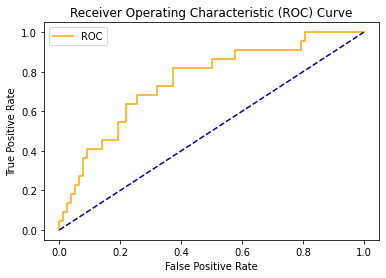

In [18]:
from sklearn.metrics import roc_curve
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    plt.plot(t_y, p_y, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

fper, tper, thresholds = roc_curve(valY, pred_Y) 
plot_auc(fper, tper)

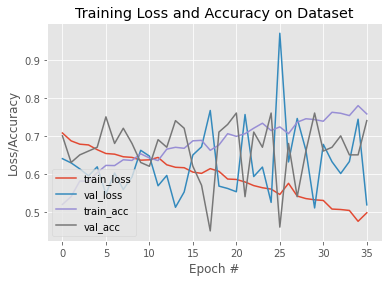

In [19]:
def plot_history(history):
    
    # Todo
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

plot_history(history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [20]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.preprocessing import binarize
precision, recall, thresholds = precision_recall_curve(valY.astype(int), pred_Y)
f1_scores = []
for i in thresholds:
    f1 = f1_score(valY.astype(int), binarize(pred_Y,i))
    f1_scores.append(f1)
    
print("The f1-score for the model: {}".format(max(f1_scores)))

# Todo

The f1-score for the model: 0.5283018867924528


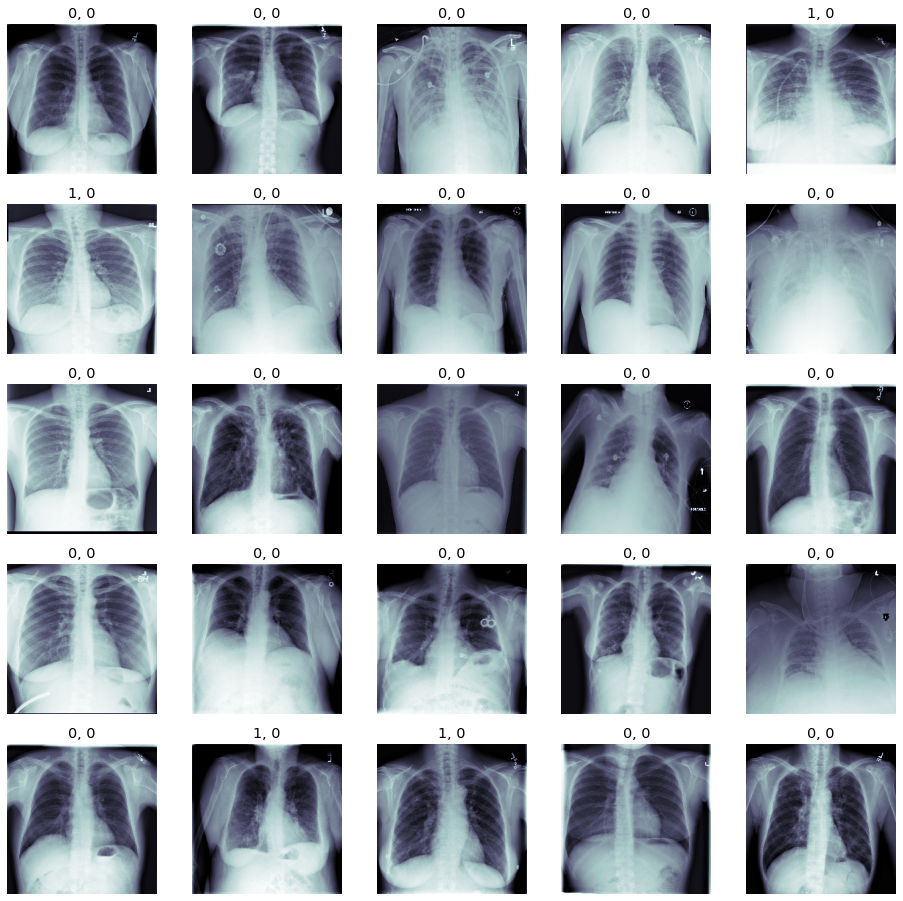

In [21]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo
THRESHOLD = 0.7
fig, m_axs = plt.subplots(5, 5, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [22]:
## Just save model architecture to a .json:

model_json = model.to_json()
with open("final_model.json", "w") as json_file:
    json_file.write(model_json)